# Effects of molecular complexity on classification performance

A demo which analyzes how the classification performance is affected by varying the molecular complexity of the chemically complex spectra. Cohorts are created at different levels of molecular complexity using the _generate_spectra_ function. Each cohort is then cross-validated upon to calculate the area under the ROC curve of the classification. The Sci-kit learn package is used for the machine learning analysis.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from spectral_generator import generate_spectra

## Loading input data 

Spectral data is used for calibrating the model. Data from the lung cancer vs. non-symptomatic controls is used for this demo. Water measurement are loaded in as well to calculate the measurement noise.

### Blood serum spectra

In [2]:
serum_spectra = pd.concat((pd.read_csv('data/dataset_1_part_%s.csv' % f.zfill(2)) for f in np.arange(1, 21).astype(str)), ignore_index=True) # load the cancer and non-cancer spectra from file

In [3]:
X = serum_spectra.iloc[0:100000, 1:] # matrix containing the spectra of lung cancer and control samples. samples in rows, wavenumers in columns.
X.columns = X.columns.astype(float)

y = serum_spectra.iloc[0:100000, 0] # vector containing the sample labels.
y = y.replace({'lung cancer control': 0, 'lung cancer case': 1})

### Water spectra

In [4]:
water_spectra = pd.read_csv('data/dataset_2.csv') # load the mean-subtracted water spectra from file.
water_spectra.columns = water_spectra.columns.astype(float)

## Defining the calibration parameters

Parameters are calculated from the input data and will be given as inputs to the _spectral_generator_ function.

### Calculating the biological properties

In [5]:
mu_neg = X[y==0].mean(axis=0) # mean spectrum of control samples.
mu_pos = X[y==1].mean(axis=0) # mean spectrum of case samples.

B_neg = X[y==0] - mu_neg # calibration vectors for control samples.
B_pos = X[y==1] - mu_pos # calibration vectors for case samples.

### Calculating the measurement noise

In [6]:
epsilon_std = water_spectra.std(axis=0) # standard deviation across the spectral features of the water measurements
epsilon_std *= 9.15 # scaling factor, to account for the l2 vector normalization in the preprocessing of the sera measurements

## Classification pipeline

An L2-regularized logistic regression binary classifier is used.
Model performance is estimated in a 10 fold cross-validation on standardized features.
The regularization strength of the logistic regression is tuned in an inner 3 fold cross-validation on each training split of the outer cross-validation.

In [7]:
cv_3  = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

clf = LogisticRegression(penalty='l2', tol=1e-2, max_iter=100000)

pipeline = Pipeline([('scale', StandardScaler(with_mean=True, with_std=True)),
                     ('clf', clf)])

estimator = GridSearchCV(estimator=pipeline, 
                         param_grid={'clf__C': 2. ** np.arange(-12, 15, 3)},
                         cv=cv_3, scoring='roc_auc', n_jobs=1, 
                         error_score='raise', verbose=0)

## Effects of molecular complexity

A set of different calibration vectors (which model the individual component spectra) are tested. The number of calibration vectors is varied to simulate varying molecular/chemical complexity of the serum-based samples. Multiple cohorts are generated for number of selected vectors. Classification performance is then assessed in a 10-fold cross-validation on each generated cohort. A classification model is fit and the area under the ROC curve (ROC-AUC) gets calculated for each cross-validation split. ROC-AUC values are then averaged across all folds each selected simulation parameter.

In [8]:
# set the number of calibration vectors to be tested.
# multiple cohorts will be generated for each tested number in the list, to vary the molecular complexity.
m_calibration_vectors = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

# set the sample size for cases (pos) and controls (neg).
n_pos = n_neg = 523

# set the number of times to repeat the cross-validation for each entry in m_calibration_vectors.
# different cohorts will be created in each repetition.
# the higher the number, the more robust the classification performance estimation is (especially for smaller sample sizes).
n_repeats = 10

In [9]:
results = [] # list to store the classification result of each parameter combination.
random_state = 0 # random state to be incremented such that each generated cohort is based on a different random seed.

i = 0
for m in m_calibration_vectors:
    start = time.time() # to monitor how much time is taken in each loop iteration.
    i += 1
    print('m=%d' % m, end='\t')

    roc_aucs_train = [] # list to store the calculated roc_aucs for the training sets for all repetitions and CV splits.
    roc_aucs_test = [] # list to store the calculated roc_aucs for the testing sets for all repetitions and CV splits.
    for j in range(n_repeats):
        random_state += 1
        
        # sample (without replacement) m vectors from the calibration matrix B for cases and controls.
        B_neg_sampled = B_neg.sample(m, random_state=random_state)
        B_pos_sampled = B_pos.sample(m, random_state=random_state)
        
        # the calibrated level of biological variability for cases and controls, given the current molecular complexity.
        beta_std_neg = 1/np.sqrt(B_neg_sampled.shape[0])
        beta_std_pos = 1/np.sqrt(B_pos_sampled.shape[0])
        
        X_gen, y_gen = generate_spectra(B_neg=B_neg_sampled, B_pos=B_pos_sampled, 
                                        mu_neg=mu_neg, mu_pos=mu_pos, 
                                        n_neg=n_neg, n_pos=n_pos,
                                        beta_std_neg=beta_std_neg, beta_std_pos=beta_std_pos, 
                                        epsilon_std=epsilon_std,
                                        random_state=random_state)

        scores = cross_validate(estimator=estimator,
                                X=X_gen, y=y_gen, # use the generated cohort as the input to the cv.
                                cv=cv_10, 
                                scoring='roc_auc',
                                verbose=0, 
                                n_jobs=-1, # using all cores available to evaluate the cv splits in parallel.
                                return_train_score=True,
                                error_score='raise')

        roc_aucs_train.extend(scores['train_score'])
        roc_aucs_test.extend(scores['test_score'])

    # append the result for the current parameter
    results.append({
        'm': m, 
        'cv_roc_auc_mean_train': np.mean(roc_aucs_train),
        'cv_roc_auc_std_train': np.std(roc_aucs_train),
        'cv_roc_auc_mean_test': np.mean(roc_aucs_test),
        'cv_roc_auc_std_test': np.std(roc_aucs_test),
    })

    print('roc_auc_train=%.2f ± %.2f' % (results[-1]['cv_roc_auc_mean_train'], results[-1]['cv_roc_auc_std_train']), end=', ')
    print('roc_auc_test=%.2f ± %.2f' % (results[-1]['cv_roc_auc_mean_test'], results[-1]['cv_roc_auc_std_test']), end=', ')
    print('elpsd %ds' % int(time.time()-start))

m=1	roc_auc_train=1.00 ± 0.00, roc_auc_test=1.00 ± 0.00, elpsd 11s
m=2	roc_auc_train=1.00 ± 0.00, roc_auc_test=1.00 ± 0.00, elpsd 10s
m=4	roc_auc_train=1.00 ± 0.00, roc_auc_test=1.00 ± 0.00, elpsd 13s
m=8	roc_auc_train=1.00 ± 0.00, roc_auc_test=1.00 ± 0.00, elpsd 21s
m=16	roc_auc_train=1.00 ± 0.00, roc_auc_test=1.00 ± 0.00, elpsd 48s
m=32	roc_auc_train=1.00 ± 0.00, roc_auc_test=1.00 ± 0.00, elpsd 93s
m=64	roc_auc_train=1.00 ± 0.00, roc_auc_test=0.98 ± 0.01, elpsd 147s
m=128	roc_auc_train=1.00 ± 0.00, roc_auc_test=0.94 ± 0.03, elpsd 173s
m=256	roc_auc_train=0.99 ± 0.01, roc_auc_test=0.90 ± 0.03, elpsd 197s
m=512	roc_auc_train=0.98 ± 0.02, roc_auc_test=0.88 ± 0.03, elpsd 175s


## Display results

In [10]:
df_results = pd.DataFrame(results)
display(df_results)

,m,cv_roc_auc_mean_train,cv_roc_auc_std_train,cv_roc_auc_mean_test,cv_roc_auc_std_test
0,1,1.000000,0.000000e+00,1.000000,0.000000
1,2,1.000000,0.000000e+00,1.000000,0.000000
2,4,1.000000,8.989361e-07,0.999993,0.000072
3,8,1.000000,0.000000e+00,1.000000,0.000000
4,16,1.000000,0.000000e+00,1.000000,0.000000
5,32,1.000000,0.000000e+00,0.999723,0.000787
6,64,1.000000,0.000000e+00,0.984154,0.010910
7,128,0.999563,8.707427e-04,0.939847,0.027445
8,256,0.994041,8.838821e-03,0.897197,0.030257
9,512,0.977505,2.041946e-02,0.876034,0.032127


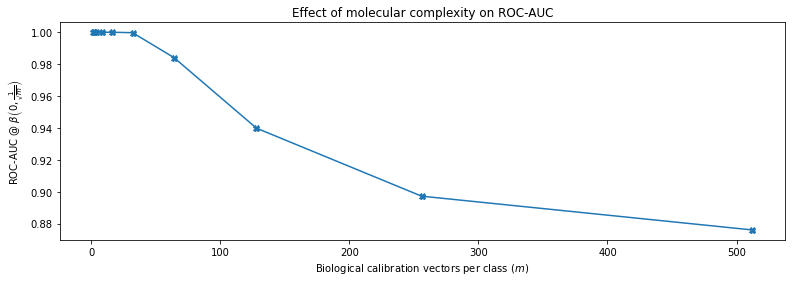

In [11]:
fig = plt.figure(figsize=(13, 4))
plt.title('Effect of molecular complexity on ROC-AUC')
plt.plot(df_results['m'], df_results['cv_roc_auc_mean_test'], marker='X')
plt.xlabel('Biological calibration vectors per class ($m$)')
plt.ylabel(r'ROC-AUC @ $\beta\left(0, \frac{1}{\sqrt{m}}\right)$')
plt.show()